# Who Bears the Burden? Decoding Climate Equity with PCA

In this analysis, we harness Principal Component Analysis (PCA) to dissect the multifaceted issue of climate equity. Our aim is to transform complex data covering GDP, population metrics, historical emissions, and adaptation scores into distinct insights. These insights are designed to shed light on the varying responsibilities and capabilities of nations within the global climate context, offering a detailed perspective on each country’s role in both contributing to and combating climate change.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Set the visual style globally for seaborn plots
sns.set(style="whitegrid", context="talk")

## Data Preparation

We embark on our exploration by compiling an extensive dataset from [Climate Watch](https://www.climatewatchdata.org/), featuring essential socio-economic indicators, emissions records, and nations' capacities for climate adaptation. This dataset lays the groundwork for our in-depth investigation into the nuances of climate equity.

In [2]:
# Load datasets
gdp = pd.read_csv('~/Downloads/ClimateWatch_SocioEconomics/CW_gdp.csv')
population = pd.read_csv('~/Downloads/ClimateWatch_SocioEconomics/CW_population.csv')
adaptation = pd.read_csv('~/Downloads/ClimateWatch_Adaptation/CW_adaptation.csv')
emission = pd.read_csv('~/Downloads/ClimateWatch_HistoricalEmissions/CW_HistoricalEmissions_PIK.csv')

## Feature Engineering

Armed with our comprehensive dataset, we next sculpt a set of indicators that capture the core aspects of climate equity from four pivotal perspectives: **Responsibility**, **Capability**, **Equality**, and **Climate Risk**. These meticulously designed indicators serve as our gateway to unraveling the complex interplay between nations' historical roles in climate change and their current capacities for action.

1. Responsibility

    * **Historical Emissions**: Captures the aggregate emissions from 1960 to 2015, offering a lens on long-term environmental impact.
    * **Current Emissions**: Highlights the emissions from 2016 to 2020, emphasizing recent contributions in the post-Paris Agreement era.

2. Capability

    * **GDP Per Capita**: Acts as a barometer of economic strength, indicating a nation's financial capacity for climate-related actions.

3. Equality

    * **Historical Cumulative Per Capita Emissions**: Normalizes emissions from 1960 to 2015 by population, providing a per capita view of historical contributions.
    * **Current Cumulative Per Capita Emissions**: Offers a per capita analysis of emissions from 2016 to 2020, underscoring recent individual contributions.

4. Climate Risk
    * **Readiness**: Evaluates a country's readiness to deploy investment in adaptation initiatives, measured through economic, governance, and societal metrics.
    * **Vulnerability**: Assesses the susceptibility of nations to climate change impacts, considering factors such as exposure, sensitivity, and adaptive capacity across vital sectors.

In [3]:
# Period definitions
post_industrial = [str(year) for year in range(1960, 2015)]
post_paris_agreement = [str(year) for year in range(2016, 2020)]

# Preprocess Emission Data
emission = emission[(emission['gas'] == 'KYOTOGHG') & (emission['sector'] == 'Total excluding LULUCF')]
emission['hist_emission'] = emission[post_industrial].sum(axis=1)
emission['current_emission'] = emission[post_paris_agreement].sum(axis=1)

# Preprocess Population Data for Per Capita Calculations
population['hist_population'] = population[post_industrial].sum(axis=1)
population['current_population'] = population[post_paris_agreement].sum(axis=1)
emission = emission.merge(population[['Country Code', 'hist_population', 'current_population']], left_on='country', right_on = 'Country Code')

# Calculate Emissions Per Capita
emission['hist_emission_per_capita'] = emission['hist_emission'] / emission['hist_population']
emission['current_emission_per_capita'] = emission['current_emission'] / emission['current_population']

# Preprocess GDP Data for GDP Per Capita Calculation
gdp = gdp[['Country Code', 'Country', '2020']]
population = population[['Country Code', 'Country', '2020']]
gdp_pop_merged = gdp.merge(population, on=('Country Code', 'Country'), suffixes=('_gdp', '_population'))
gdp_pop_merged['gdp_per_capita'] = gdp_pop_merged['2020_gdp'] / gdp_pop_merged['2020_population']

Following the creation of these indicators, we synthesize them into a unified DataFrame, setting the stage for a thorough analysis that aims to decode the intricate dynamics of climate equity.

In [4]:
# Merge datasets
df = emission[['country', 'hist_emission', 'current_emission', 'hist_emission_per_capita', 'current_emission_per_capita']].merge(gdp_pop_merged, left_on = 'country', right_on = 'Country Code').merge(adaptation, on = 'country')
df = df[['country', 'Country', 'hist_emission', 'current_emission', 'hist_emission_per_capita', 'current_emission_per_capita', 'gdp_per_capita', 'vulnerability', 'readiness']]
df = df.rename(columns = {'country' : 'iso3c', 'Country': 'country'}).dropna()
df.head()

,iso3c,country,hist_emission,current_emission,hist_emission_per_capita,current_emission_per_capita,gdp_per_capita,vulnerability,readiness
0,AFG,Afghanistan,1171.20,178.20,0.000001,0.000001,516.747871,0.592742,0.221415
1,AGO,Angola,3137.60,400.70,0.000005,0.000003,1631.431691,0.504155,0.251473
2,ALB,Albania,348.94,41.27,0.000002,0.000004,5332.160475,0.429632,0.426645
4,ARE,United Arab Emirates,4639.65,944.00,0.000034,0.000025,36284.555243,0.374357,0.599504
5,ARG,Argentina,13276.00,1375.00,0.000008,0.000008,8585.694742,0.403182,0.378078


## Unveiling Connections: Correlation Analysis

Before diving into the PCA, we took a detour into correlation analysis to tease out the intricate relationships between our indicators. This essential step not only illuminated the interplay between economic strength, emissions, and climate vulnerability but also set a solid foundation for our subsequent, more nuanced exploration with PCA.

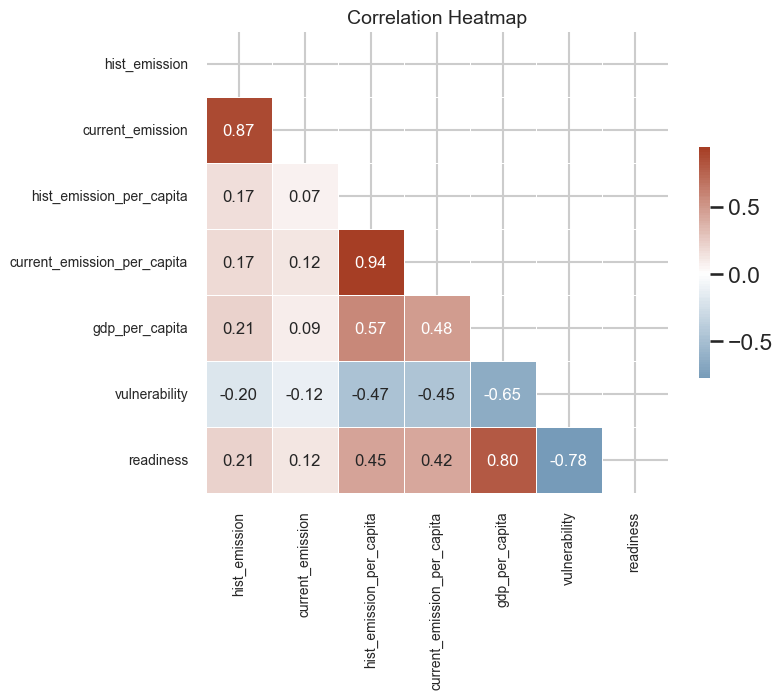

In [5]:
# Create a custom colormap
colors = ["#5c88ab", "white", "#a63e25"]
cmap = LinearSegmentedColormap.from_list(name='custom_coolwarm', colors=colors, N=100)

# Calculate the correlation matrix, excluding non-numeric columns
corr_matrix = df.drop(columns=['iso3c', 'country']).corr()

# Generate a mask for the upper triangle to avoid redundant information
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"size": 12}, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

Key insights from our correlation analysis emerged distinctly:

* The bond between historical and current emissions is tight, indicating a consistent trajectory for countries with a legacy of high emissions.

* This pattern persists even when looking at emissions on a per capita basis, highlighting a continuous environmental footprint over time.

* GDP per capita emerges as a pivotal factor, displaying a positive correlation with readiness for climate action and a negative one with vulnerability to climate impacts. This underscores the critical role of economic robustness in enhancing a nation's resilience and reducing its susceptibility to climate challenges.

## Pivoting to Principal Component Analysis (PCA)

Having laid the groundwork with our correlation analysis, we pivot to PCA. This strategic move allows us to simplify the complexity of our dataset, preserving the essence of its variance. This step is crucial in highlighting the dominant patterns within our data, affording us a clear, distilled perspective on climate equity. It's important to standardize all features in PCA to ensure uniformity in magnitude across the board.

In [6]:
# PCA pipeline
numeric_cols = df.select_dtypes(include=['float64', 'int']).columns
pca_pipeline = make_pipeline(StandardScaler(), PCA())
pca_results = pca_pipeline.fit_transform(df[numeric_cols])

# Results to DataFrame
pca_df = pd.DataFrame(pca_results, columns=[f'PC{i+1}' for i in range(len(numeric_cols))])

pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-2.276897,0.279147,0.636698,0.724953,0.140161,0.002592,0.018806
1,-1.451782,0.137628,0.524277,0.040030,0.381136,0.007731,-0.067317
2,-0.620634,-0.155351,-0.455687,-0.367195,-0.105675,-0.026463,0.042776
3,3.507648,-1.176939,1.693143,0.212432,-0.236847,0.109332,-0.476551
4,0.042970,0.123340,0.164100,-0.518749,0.285558,-0.022675,0.047900


## Honing in on the Principal Components

The journey through PCA led us to a decisive phase: selecting the optimal number of principal components. Employing methods like Kaiser's rule (eigenvalues greater than 1) and scree plots, coupled with a careful examination of explained variance charts, we sought deeper understanding and clarity on the PCA outcome.

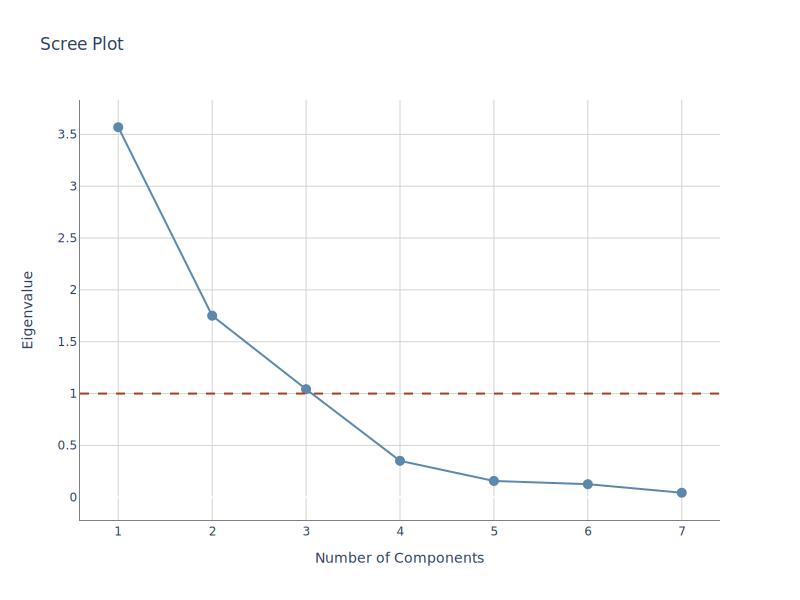

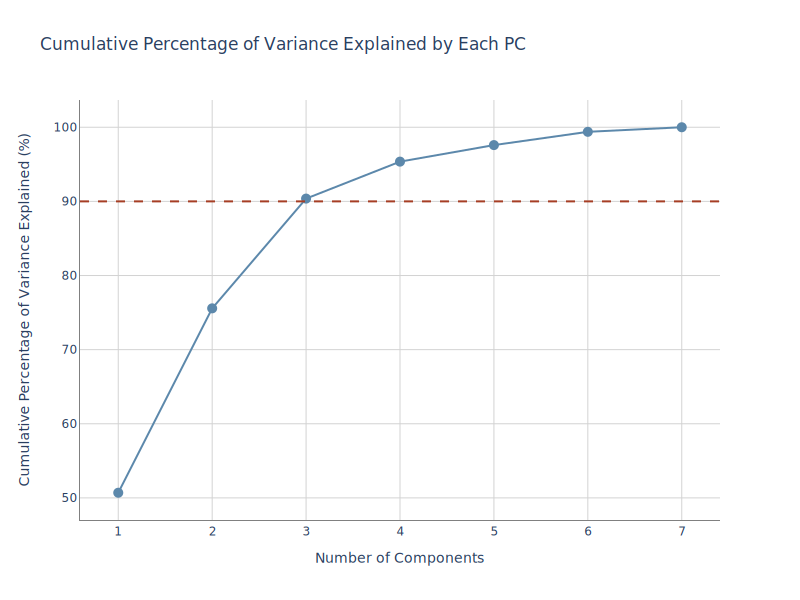

In [7]:
# Scree plot
explained_variance = pca_pipeline.named_steps['pca'].explained_variance_
fig = go.Figure(data=go.Scatter(x=list(range(1, len(explained_variance) + 1)), y=explained_variance, mode='lines+markers',
                                line=dict(color='#5c88ab'), marker=dict(color='#5c88ab', size=10), name='Eigenvalue'))
fig.add_hline(y=1, line=dict(color='#a63e25', dash='dash'), name='Kaiser criterion (y=1)')
fig.update_layout(title="Scree Plot", plot_bgcolor='white',
                  xaxis=dict(title='Number of Components', showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray'),
                  yaxis=dict(title='Eigenvalue', showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray'),
                  width=800, height=600)
fig.show('svg')


# Cumulative explained variance plot
explained_variance_ratio = pca_pipeline.named_steps['pca'].explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio) * 100
fig = go.Figure(data=go.Scatter(x=list(range(1, len(cumulative_explained_variance) + 1)), y=cumulative_explained_variance, mode='lines+markers',
                                line=dict(color='#5c88ab'), marker=dict(color='#5c88ab', size=10), name='Cumulative Variance'))
fig.add_hline(y=90, line=dict(color='#a63e25', dash='dash'), name='90% Explained Variance')
fig.update_layout(title='Cumulative Percentage of Variance Explained by Each PC', plot_bgcolor='white',
                  xaxis=dict(title='Number of Components', showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray'),
                  yaxis=dict(title='Cumulative Percentage of Variance Explained (%)', showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray', tickformat='.0f'),
                  width=800, height=600)
fig.show('svg')

* The consensus from both Kaiser's rule and scree plots was clear, pointing us towards retaining three principal components that together account for over 90% of the variance.

## Decoding Principal Components

Diving into the PCA results, we extracted the components to spotlight the most influential features.

In [8]:
# Extract the PCA from the pipeline
pca = pca_pipeline.named_steps['pca']
components = pca.components_
feature_names = df[numeric_cols].columns

# Convert the components to a DataFrame
loadings_df = pd.DataFrame(components.T, columns=[f'PC{i+1}' for i in range(len(components))], index=feature_names)

# Melt the DataFrame for easy plotting
melted_df = loadings_df.reset_index().melt(id_vars='index', var_name='component', value_name='value')
melted_df['absolute_value'] = melted_df['value'].abs()
melted_df['color'] = melted_df['value'].apply(lambda x: '#a63e25' if x >= 0 else '#5c88ab')

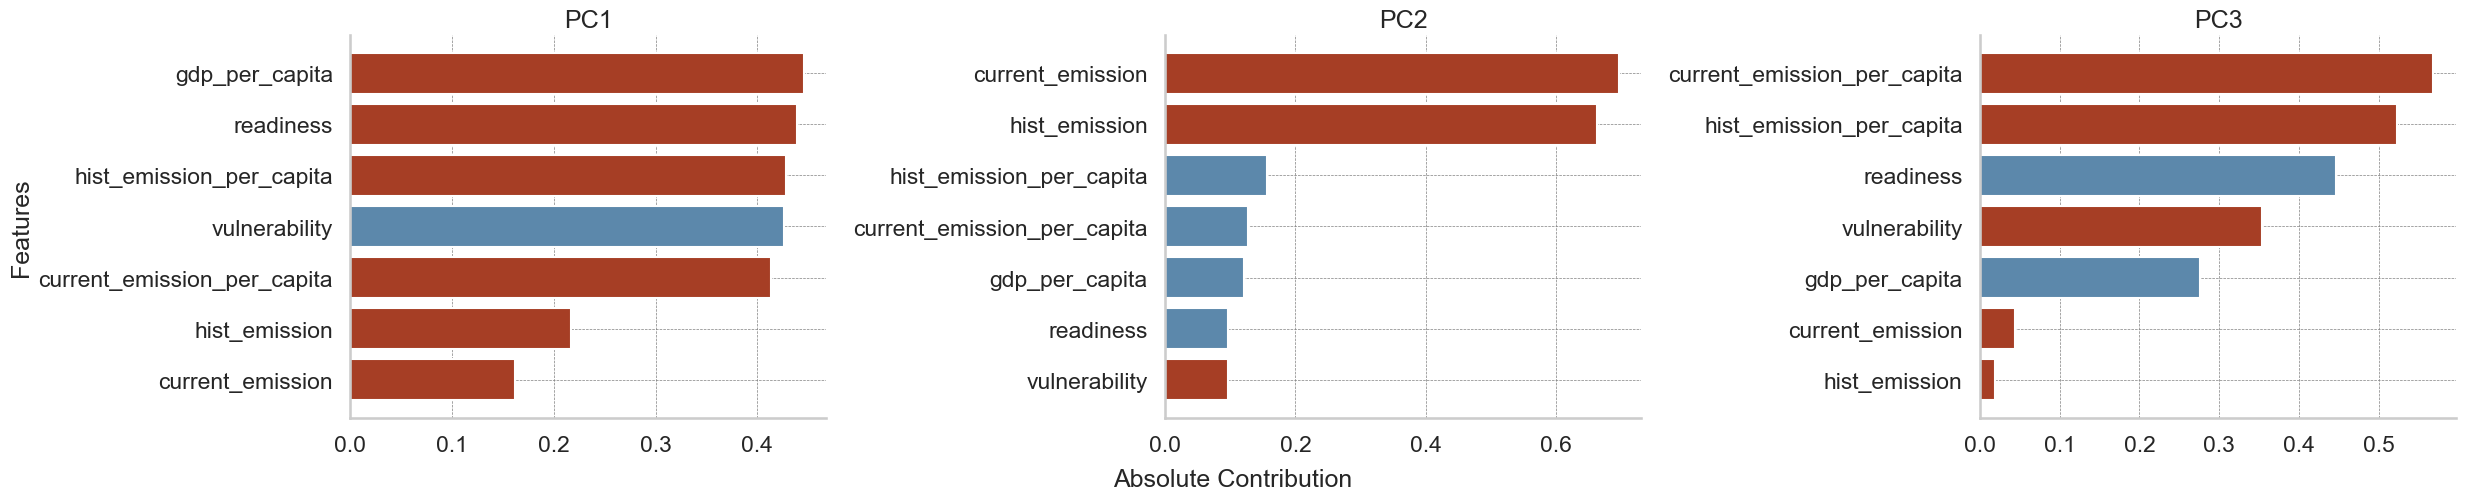

In [9]:
# Prepare subplots for the first three principal components
fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=False)

for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    data = melted_df[melted_df['component'] == pc].sort_values(by='absolute_value', ascending=True)

    for _, row in data.iterrows():
        axes[i].barh(row['index'], row['absolute_value'], color=row['color'])
    axes[i].set_title(f'{pc}')

# Common y-label
axes[0].set_ylabel('Features')

# Common X label
fig.text(0.5, 0.005, 'Absolute Contribution', ha='center', va='center')

# Customizing each subplot for a consistent and cleaner look
for ax in axes:
    ax.set_axisbelow(True)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

Delving into the heart of our PCA, we unveiled three principal components that sketch a vivid portrayal of the global climate equity canvas:

* PC1 (**Wealth and Weathering**): Affluence translates into resilience here, illustrating how wealthier nations are better positioned to confront climate adversities. This component emphasizes the synergy between economic prosperity and climate resilience.

* PC2 (**Big Emitters**): This is where the giants of emissions stand out, marking territories on the global emissions map. These nations play a crucial role in the narrative of carbon footprints, underscoring the imperative for focused efforts on emissions reduction.

* PC3 (**High Carbon, High Risk**): Casting the spotlight on nations balancing on the brink, where high emissions meet high vulnerability. This delicate equilibrium accentuates the pressing call to action, advocating for significant measures in emissions mitigation and strengthening adaptive capacities.

## Visualizing the Climate Equity Landscape in PCA Space

As we approach the culmination of our analysis, we bring our findings to vivid life through visualizations in PCA space. This crucial step not only animates our data but also casts a spotlight on the multifaceted roles and responsibilities of nations in the arena of climate equity.


In [10]:
# Combine the lists of countries to annotate in the plots
key_countries_annotations = {
    'PC1_vs_PC2': ['CHN', 'RUS', 'USA', 'QAT', 'LUX', 'IDN', 'IND', 'MDV', 'FJI', 'SOM', 'AUS', 'CAN', 'DEU', 'JPN'],
    'PC2_vs_PC3': ['USA', 'CHN', 'QAT', 'KWT', 'ARE', 'NOR', 'CHE', 'RUS', 'IND', 'LUX', 'JPN', 'GBR', 'BRA']
}

In [11]:
# Function to annotate key countries for a given plot
def annotate_key_countries(fig, df, comp1, comp2, annotation_set):
    for iso3c in key_countries_annotations[annotation_set]:
        country_row = df[df['iso3c'] == iso3c]
        if not country_row.empty:
            fig.add_annotation(x=country_row[comp1].iloc[0], y=country_row[comp2].iloc[0], text=iso3c,
                               showarrow=False,
                               font=dict(color="black"),
                               xanchor="center", yanchor="bottom")
    return fig

In [12]:
pca_df['iso3c'] = df['iso3c'].values

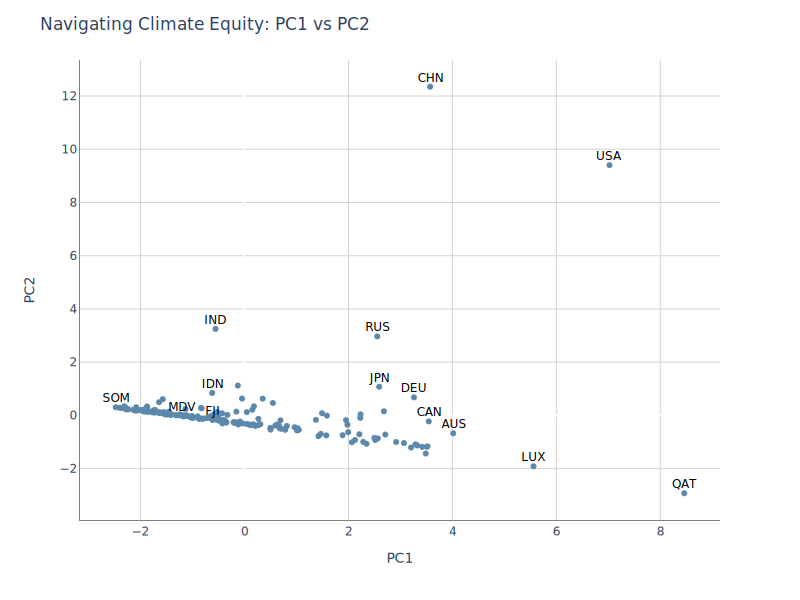

In [13]:
# Scatter plot for PC1 vs PC2
fig_pc1_pc2 = px.scatter(pca_df, x='PC1', y='PC2', hover_name='iso3c', color_discrete_sequence=['#5c88ab'])
fig_pc1_pc2 = annotate_key_countries(fig_pc1_pc2, pca_df, 'PC1', 'PC2', 'PC1_vs_PC2')
fig_pc1_pc2.update_layout(title="Navigating Climate Equity: PC1 vs PC2", plot_bgcolor='white', width=800, height=600)
fig_pc1_pc2.update_xaxes(showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray')
fig_pc1_pc2.update_yaxes(showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray')
fig_pc1_pc2.show('svg')

Through the lens of PC1 and PC2, we unveil the strategic positions of countries:

* **High PC1 & High PC2 (USA, CHN)**: Here stand the economic powerhouses, also the top emitters. Their pivotal role in global emissions and climate adaptation efforts places them at the forefront of the action. With ample resources at their disposal, they are well-positioned to spearhead transformative change.

* **High PC1 & Low PC2 (QAT, LUX)**: These nations, while smaller in emissions, wield considerable influence due to their wealth. They exemplify how economic prosperity can be leveraged for global climate benefit, underscoring the power of investment in innovation and support for broader climate initiatives.

* **Low PC1 & High PC2 (IDN, IND)**: Emerging economies grappling with their emissions footprint. The path forward for these nations hinges on collaborative efforts and access to clean technologies, highlighting the importance of international support in achieving sustainable development.

* **Low PC1 & Low PC2 (MDV, FJI)**: Small in economic size and emissions but disproportionately affected by climate impacts. These nations underscore the critical need for a collective global response, advocating for support mechanisms that address the skewed burden of climate change.

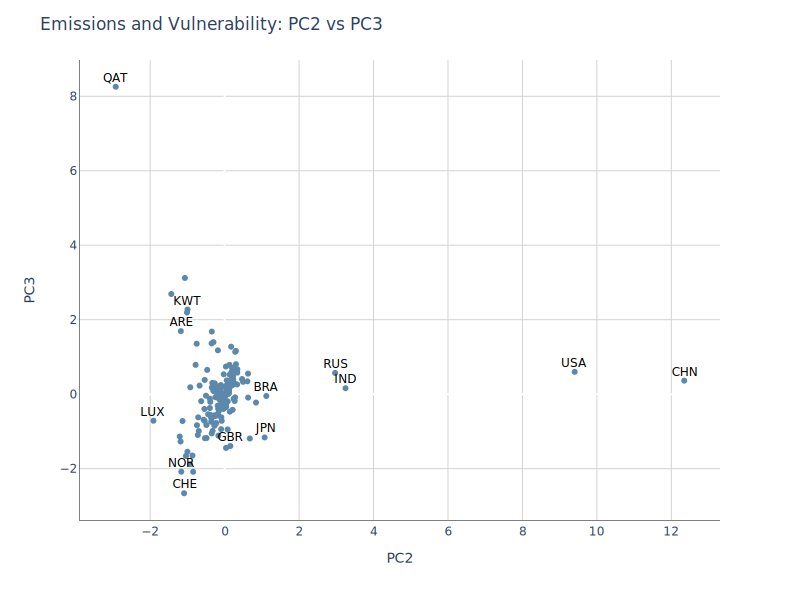

In [14]:
# Scatter plot for PC2 vs PC3
fig_pc2_pc3 = px.scatter(pca_df, x='PC2', y='PC3', hover_name='iso3c', color_discrete_sequence=['#5c88ab'])
fig_pc2_pc3 = annotate_key_countries(fig_pc2_pc3, pca_df, 'PC2', 'PC3', 'PC2_vs_PC3')
fig_pc2_pc3.update_layout(title="Emissions and Vulnerability: PC2 vs PC3", plot_bgcolor='white', width=800, height=600)
fig_pc2_pc3.update_xaxes(showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray')
fig_pc2_pc3.update_yaxes(showline=True, linewidth=1, linecolor='gray', gridcolor='lightgray')
fig_pc2_pc3.show('svg')

Exploring the interplay between PC2 and PC3 sheds light on emissions versus risk and readiness:

* **High PC2 & Low PC3 (USA, CHN)**: Major emitters with significant capabilities for addressing climate change. Their technological and economic capacities earmark them as leaders in emissions reduction and adaptation strategies, embodying the potential of resourceful action.

* **Low PC2 & High PC3 (QAT, KWT, ARE)**: Nations rich in fossil fuels face the irony of vulnerability to the very crisis they contribute to. This scenario calls for urgent diversification and enhancement of resilience, emphasizing the need to future-proof economies against climate adversities.

* **Low PC2 & Low PC3 (NOR, CHE, SWE)**: The exemplars of low emissions and reduced risk, showcasing the benefits of sustainable practices and proactive investments in resilience. Their success stories highlight the attainable balance between environmental stewardship and economic stability.


Let's explore the principal components together through a dynamic 3D plot!

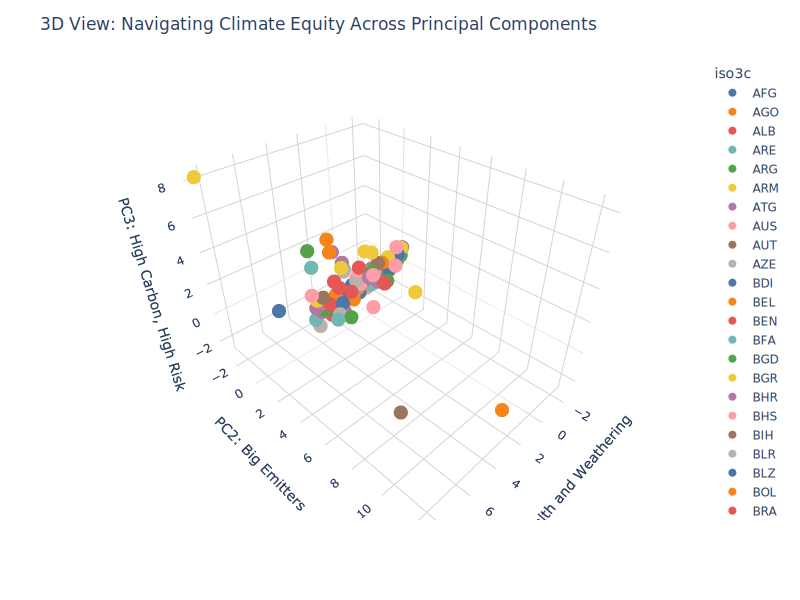

In [15]:
fig_3d = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    hover_name='iso3c',
    color='iso3c',
    color_discrete_sequence=px.colors.qualitative.T10
)

fig_3d.update_layout(
    title="3D View: Navigating Climate Equity Across Principal Components",
    paper_bgcolor='white',
    plot_bgcolor='white',
    scene=dict(
        xaxis=dict(backgroundcolor='white',
                   gridcolor='lightgrey'),
        yaxis=dict(backgroundcolor='white',
                   gridcolor='lightgrey'),
        zaxis=dict(backgroundcolor='white',
                   gridcolor='lightgrey'),
        xaxis_title='PC1: Wealth and Weathering',
        yaxis_title='PC2: Big Emitters',
        zaxis_title='PC3: High Carbon, High Risk'
    ),
    width=800,
    height=600
)

fig_3d.show('svg')

## In Conclusion: A Call to Collective Action

Our exploration through PCA illuminates the global challenge of climate equity as a complex mosaic of responsibilities and capabilities. From economic titans with significant emissions to smaller states facing dire impacts, the narrative of climate action is rich with diversity and urgency.

* **Economic Giants (USA, China)**: These nations, armed with substantial resources, are tasked with a dual mandate: aggressively cutting emissions and leading global adaptation initiatives. Their role is pivotal in setting the pace for meaningful global climate action.

* **Wealthy Influencers (Qatar, Luxembourg)**: Their story is one of influence beyond size, demonstrating how strategic investments and support can amplify global climate efforts, regardless of their own emissions footprint.

* **Emerging Voices (Indonesia, India)**: Here lies the call for collaboration, where the intersection of growth and emissions necessitates global partnerships to pave the way for sustainable development and access to green technologies.

* **Vulnerable Frontiers (Maldives, Fiji)**: These nations bring to light the disproportionate impact of climate change, serving as a stark reminder of the urgent need for an inclusive, united global response.

At the heart of our findings is a clear message: navigating the complexities of climate equity requires more than acknowledgment of emissions—it demands a nuanced understanding of each nation's unique capacity and responsibility in forging a path towards a balanced and equitable climate future. In this collective journey, solidarity, shared goals, and mutual support are the cornerstones of success, urging us towards a concerted effort to ensure a sustainable and just world for all.
